# Pre-Process data for CF

+ Read and Merge Data: Load the ratings.dat, users.dat, and movies.dat files, and merge them into a single DataFrame.
+ Filter Users with ≥ 5 Ratings: Filter out users who have less than 5 ratings.
+ Calculate Pearson Correlation  
+ Find Valid Neighbors: Use the `pearson_correlation`` function to calculate the Pearson Correlation Coefficient matrix and then identify users who have valid neighbors based on a threshold (>=0.6).


In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
# Add the path to the constants file to the system path
sys.path.append('../../../')
from path_utils import *

# source code folder path
rec_sys_dir = get_rec_sys_directory()
print(f"Rec-sys directory: {rec_sys_dir}")

# data folder path
DATA_DIR = os.path.join(rec_sys_dir, '../data')
print(f"Data directory: {DATA_DIR}")

# data path
movies_path = os.path.join(DATA_DIR, 'ml-1m/movies.dat')
print(f'Data path: {movies_path}')
ratings_path = os.path.join(DATA_DIR, 'ml-1m/ratings.dat')
print(f'Data path: {ratings_path}')
users_path = os.path.join(DATA_DIR, 'ml-1m/users.dat')
print(f'Data path: {users_path}')

data_path = os.path.join(DATA_DIR, 'ml-1m/merged_data.dat')
print(f'Data path: {data_path}')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Rec-sys directory: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/code/notebook
Data directory: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/code/notebook/../data
Data path: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/code/notebook/../data/ml-1m/movies.dat
Data path: /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/code/notebook/../data/ml-1m/ratings.dat
Data path: /Users/tnathu-ai/VSCode/recommender-syste

In [2]:
# Read and Merge Data
def load_and_merge_data(movies_path, ratings_path, users_path):
    # Load each file
    movies = pd.read_csv(movies_path, delimiter='::', engine= 'python', header=None, names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')
    ratings = pd.read_csv(ratings_path, delimiter='::', engine= 'python', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')
    users = pd.read_csv(users_path,delimiter='::', engine= 'python', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='ISO-8859-1')
    # Merge datasets
    merged_data = pd.merge(pd.merge(ratings, users, on='UserID'), movies, on='MovieID')
    return merged_data


# Filter Users with ≥ 5 Ratings
def filter_users(data):
    user_rating_counts = data['UserID'].value_counts()
    valid_users = user_rating_counts[user_rating_counts >= 5].index.tolist()
    return data[data['UserID'].isin(valid_users)]


# Calculate Pearson Correlation Coefficient
# source RMIT courses
def pearson_correlation(interaction_matrix):
    """
    Compute the Pearson Correlation Coefficient matrix for the user-item interaction matrix.

    Args:
    interaction_matrix (csr_matrix): A sparse matrix where rows represent users and columns represent items.
                                     The values in the matrix are the ratings given by users to items.

    Returns:
    numpy.ndarray: A 2D array representing the Pearson Correlation Coefficients between each pair of users.
    """
    # Convert sparse matrix to dense format for processing
    dense_matrix = interaction_matrix.toarray()
    
    # Get the number of users
    n_users = dense_matrix.shape[0]

    # Initialize the Pearson Correlation matrix
    pearson_corr_matrix = np.zeros((n_users, n_users))

    # Small constant to avoid division by zero
    EPSILON = 1e-9

    # Iterate over each pair of users
    for i in range(n_users):
        for j in range(n_users):
            # Get the rating vectors for the current pair of users
            user_i_vec = dense_matrix[i, :]
            user_j_vec = dense_matrix[j, :]

            # Masks for rated items
            mask_i = user_i_vec > 0
            mask_j = user_j_vec > 0

            # Find indices of corrated items
            corrated_index = np.intersect1d(np.where(mask_i)[0], np.where(mask_j)[0])

            # Skip if no items are corrated
            if len(corrated_index) == 0:
                continue

            # Compute the mean rating for each user over corrated items
            mean_user_i = np.mean(user_i_vec[corrated_index])
            mean_user_j = np.mean(user_j_vec[corrated_index])

            # Compute the deviations from the mean
            user_i_sub_mean = user_i_vec[corrated_index] - mean_user_i
            user_j_sub_mean = user_j_vec[corrated_index] - mean_user_j

            # Calculate the components for Pearson correlation
            r_ui_sub_r_i_sq = np.square(user_i_sub_mean)
            r_uj_sub_r_j_sq = np.square(user_j_sub_mean)

            r_ui_sum_sqrt = np.sqrt(np.sum(r_ui_sub_r_i_sq))
            r_uj_sum_sqrt = np.sqrt(np.sum(r_uj_sub_r_j_sq))

            # Calculate Pearson correlation
            sim = np.sum(user_i_sub_mean * user_j_sub_mean) / (r_ui_sum_sqrt * r_uj_sum_sqrt + EPSILON)

            # Store the similarity in the matrix
            pearson_corr_matrix[i, j] = sim

    return pearson_corr_matrix


# Find Valid Neighbors
def get_valid_neighbors(pcc_matrix, threshold=0.6):
    valid_neighbors = {}
    for i, row in enumerate(pcc_matrix):
        valid_neighbors[i] = np.where(row > threshold)[0]
    return valid_neighbors

In [3]:
# Load and merge data
data = load_and_merge_data(movies_path, ratings_path, users_path)

print(f"Total users before filtering: {len(data['UserID'].unique())}")

# Filter users with at least 5 ratings
filtered_data = filter_users(data)

# Create User-Item Interaction Matrix
interaction_matrix = pd.pivot_table(filtered_data, index='UserID', columns='MovieID', values='Rating').fillna(0)
csr_interaction_matrix = csr_matrix(interaction_matrix.values)

# Calculate Pearson Correlation Coefficient Matrix
pcc_matrix = pearson_correlation(csr_interaction_matrix)

# Find Valid Neighbors
valid_neighbors = get_valid_neighbors(pcc_matrix)

# Print some summary
print(f"Total users after filtering: {len(filtered_data['UserID'].unique())}")
print(f"Total users with valid neighbors: {len(valid_neighbors)}")


Total users before filtering: 6040
Total users after filtering: 6040
Total users with valid neighbors: 6040


In [4]:
interaction_matrix

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
csr_interaction_matrix

<6040x3706 sparse matrix of type '<class 'numpy.float64'>'
	with 1000209 stored elements in Compressed Sparse Row format>

In [6]:
pcc_matrix

array([[ 1.        ,  0.41666667, -0.33218192, ...,  0.        ,
         0.05685735, -0.04351941],
       [ 0.41666667,  1.        ,  0.23683386, ..., -0.5       ,
         0.57207755, -0.0271435 ],
       [-0.33218192,  0.23683386,  1.        , ...,  0.5       ,
         0.30927686, -0.39528471],
       ...,
       [ 0.        , -0.5       ,  0.5       , ...,  1.        ,
         0.27116307, -0.39712226],
       [ 0.05685735,  0.57207755,  0.30927686, ...,  0.27116307,
         1.        ,  0.24230884],
       [-0.04351941, -0.0271435 , -0.39528471, ..., -0.39712226,
         0.24230884,  1.        ]])

In [7]:
valid_neighbors

{0: array([   0,   39,   46,   48,   50,   56,   65,   71,   87,   88,  112,
         142,  170,  175,  179,  212,  222,  247,  256,  279,  297,  338,
         360,  364,  368,  392,  409,  447,  467,  483,  484,  485,  488,
         493,  503,  525,  551,  561,  564,  575,  612,  635,  643,  662,
         671,  681,  688,  692,  708,  725,  731,  737,  739,  791,  793,
         820,  832,  863,  884,  892,  899,  917,  929,  932,  938,  941,
         993, 1015, 1019, 1026, 1044, 1055, 1064, 1075, 1084, 1092, 1103,
        1108, 1132, 1147, 1154, 1168, 1173, 1177, 1255, 1306, 1308, 1331,
        1335, 1348, 1354, 1367, 1368, 1378, 1387, 1393, 1405, 1427, 1428,
        1432, 1436, 1454, 1458, 1460, 1474, 1477, 1533, 1535, 1573, 1580,
        1590, 1636, 1639, 1662, 1666, 1682, 1686, 1738, 1741, 1744, 1759,
        1761, 1762, 1787, 1829, 1831, 1832, 1876, 1885, 1893, 1905, 1913,
        1943, 1945, 1974, 1975, 2027, 2081, 2098, 2127, 2140, 2145, 2148,
        2149, 2166, 2207, 2215, 223

In [7]:
# view duplicate rows
print(f"Number of duplicate rows: {len(filtered_data[filtered_data.duplicated(subset=['UserID', 'MovieID', 'Rating'], keep=False)])}")



Number of duplicate rows: 0


In [8]:
%%time

# saved the merged data in data_path
filtered_data.to_csv(data_path, index=False)
print(f"Saved merged data in {data_path}")

Saved merged data in /Users/tnathu-ai/VSCode/recommender-system/recommender-system-openAI/rec-sys/notebook/../data/ml-1m/merged_data.dat
CPU times: user 2.32 s, sys: 64.4 ms, total: 2.39 s
Wall time: 2.43 s


In [9]:
data = pd.read_csv(data_path)
data.head(3)

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama


In [10]:
# Function to plot basic statistics and EDA
def plot_eda(data):
    # Basic statistics
    print("Basic Statistics:")
    print(data.describe())

    # Distribution of ratings
    plt.figure(figsize=(8, 6))
    sns.countplot(data['Rating'])
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

    # Number of ratings per user
    user_ratings = data.groupby('UserID').size()
    plt.figure(figsize=(8, 6))
    sns.histplot(user_ratings, bins=30, kde=True)
    plt.title('Number of Ratings per User')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Count of Users')
    plt.show()

    # Number of ratings per movie
    movie_ratings = data.groupby('MovieID').size()
    plt.figure(figsize=(8, 6))
    sns.histplot(movie_ratings, bins=30, kde=True)
    plt.title('Number of Ratings per Movie')
    plt.xlabel('Number of Ratings')
    plt.ylabel('Count of Movies')
    plt.show()




Basic Statistics:
             UserID       MovieID        Rating     Timestamp           Age  \
count  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06  1.000209e+06   
mean   3.024512e+03  1.865540e+03  3.581564e+00  9.722437e+08  2.973831e+01   
std    1.728413e+03  1.096041e+03  1.117102e+00  1.215256e+07  1.175198e+01   
min    1.000000e+00  1.000000e+00  1.000000e+00  9.567039e+08  1.000000e+00   
25%    1.506000e+03  1.030000e+03  3.000000e+00  9.653026e+08  2.500000e+01   
50%    3.070000e+03  1.835000e+03  4.000000e+00  9.730180e+08  2.500000e+01   
75%    4.476000e+03  2.770000e+03  4.000000e+00  9.752209e+08  3.500000e+01   
max    6.040000e+03  3.952000e+03  5.000000e+00  1.046455e+09  5.600000e+01   

         Occupation  
count  1.000209e+06  
mean   8.036138e+00  
std    6.531336e+00  
min    0.000000e+00  
25%    2.000000e+00  
50%    7.000000e+00  
75%    1.400000e+01  
max    2.000000e+01  


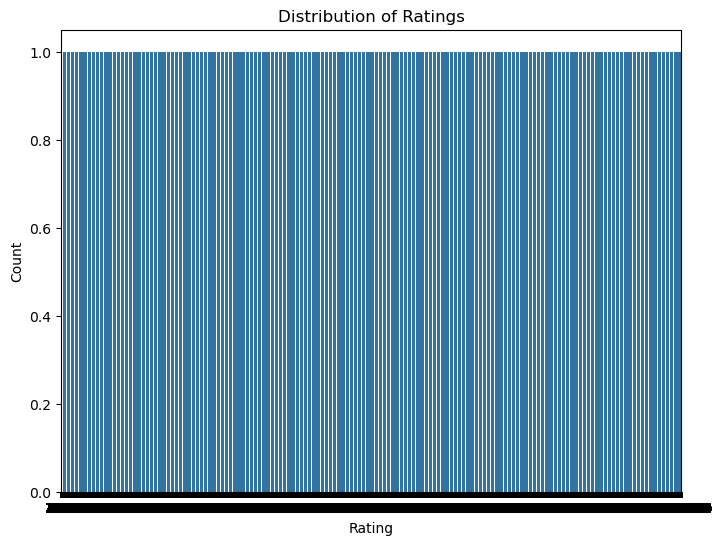

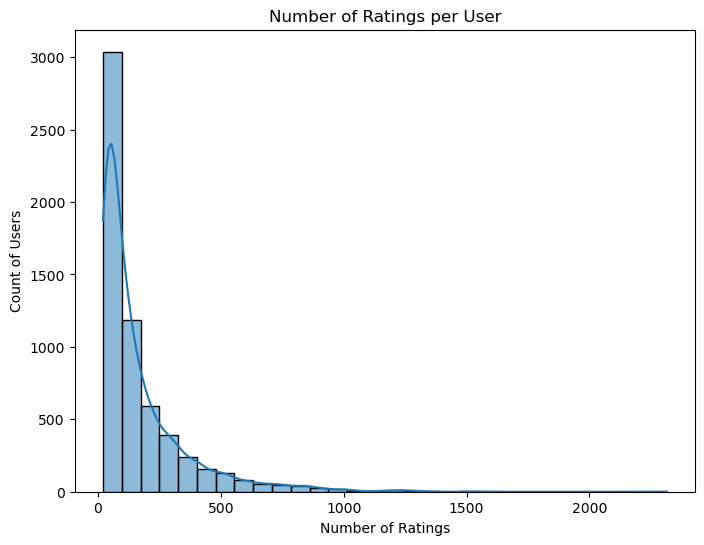

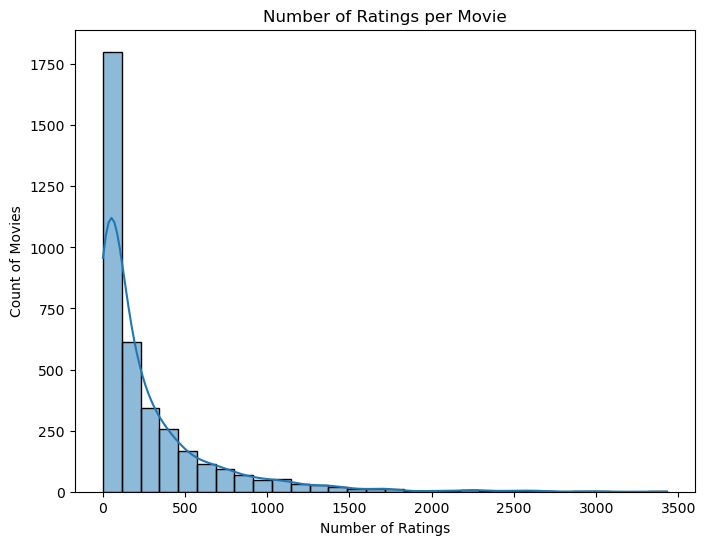

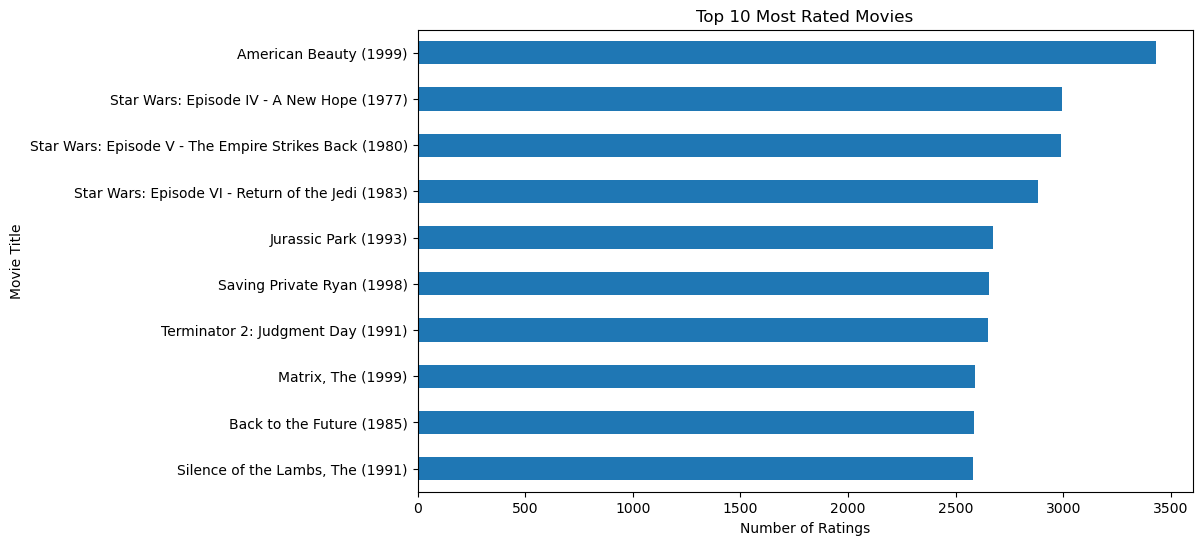

NameError: name 'user_ratings' is not defined

<Figure size 800x600 with 0 Axes>

In [11]:
# Plot EDA
plot_eda(data)

# Additional EDA: Top 10 most rated movies
top_movies = data.groupby('Title').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_movies.plot(kind='barh')
plt.title('Top 10 Most Rated Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.gca().invert_yaxis()
plt.show()

# Additional EDA: User rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(user_ratings, bins=30, kde=False)
plt.title('User Rating Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Frequency')
plt.show()

# Additional EDA: Movie rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(movie_ratings, bins=30, kde=False)
plt.title('Movie Rating Distribution')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Frequency')
plt.show()